In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = "./Train"
data_dir = pathlib.Path(data_dir)

In [3]:
batch_size = 32
img_height = 180
img_width = 180

# 1. Data Understanding and Cleaning

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6277


In [5]:
total_data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 6277 files belonging to 5 classes.


In [6]:
for key in total_data.class_names:
    length = len([name for name in os.listdir(f'./Train/{key}') if os.path.isfile(os.path.join(f'./Train/{key}', name))])
    print(f'Image in class {key} is {length}')

Image in class Banana is 1429
Image in class Cherry is 1229
Image in class Grape is 1475
Image in class Mango is 915
Image in class Peach is 1229


In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 6277 files belonging to 5 classes.
Using 5022 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 6277 files belonging to 5 classes.
Using 1255 files for validation.


In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.049237393 1.0


# 2. Data Analysis and Visualization

### Plot at least one images belonging to each class.

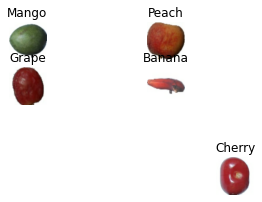

In [15]:
class_names = train_ds.class_names
printed = []

for images, labels in train_ds.take(1): 
    for i in range(25): 
        if (printed.count(class_names[labels[i]]) < 1):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            printed.append(class_names[labels[i]])
    if len(printed) == 5: 
        break

# 3. Build Model

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# 4. Training of the Model

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
157/157 [==============================] - 163s 1s/step - loss: 0.1988 - accuracy: 0.9321 - val_loss: 4.9884e-04 - val_accuracy: 1.0000
Epoch 2/10
157/157 [==============================] - 134s 851ms/step - loss: 1.5096e-04 - accuracy: 1.0000 - val_loss: 8.4872e-05 - val_accuracy: 1.0000
Epoch 3/10
157/157 [==============================] - 148s 938ms/step - loss: 5.3884e-05 - accuracy: 1.0000 - val_loss: 4.4351e-05 - val_accuracy: 1.0000
Epoch 4/10
157/157 [==============================] - 159s 1s/step - loss: 3.0467e-05 - accuracy: 1.0000 - val_loss: 2.7764e-05 - val_accuracy: 1.0000
Epoch 5/10
157/157 [==============================] - 124s 790ms/step - loss: 1.9671e-05 - accuracy: 1.0000 - val_loss: 1.8899e-05 - val_accuracy: 1.0000
Epoch 6/10
157/157 [==============================] - 143s 907ms/step - loss: 1.3791e-05 - accuracy: 1.0000 - val_loss: 1.3785e-05 - val_accuracy: 1.0000
Epoch 7/10
157/157 [==============================] - 121s 769ms/step - loss: 1.0264e-

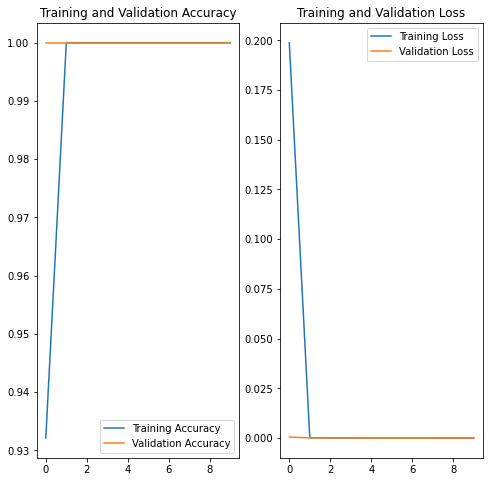

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 5. Results and Prediction

Identified to Banana with a 100.00 percent confidence.


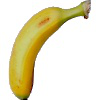

In [21]:
banana_path = "./Test/1_100(2).jpg"

img = tf.keras.utils.load_img(
    banana_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Identified to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(banana_path))

Identified to Cherry with a 100.00 percent confidence.


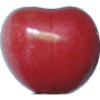

In [22]:
cherry_path = "./Test/5_100.jpg"

img = tf.keras.utils.load_img(
    cherry_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Identified to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(cherry_path))

Identified to Mango with a 100.00 percent confidence.


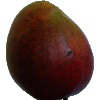

In [23]:
mango_path = "./Test/11_100.jpg"

img = tf.keras.utils.load_img(
    mango_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Identified to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(mango_path))

Identified to Grape with a 100.00 percent confidence.


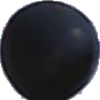

In [24]:
grape_path = "./Test/14_100.jpg"

img = tf.keras.utils.load_img(
    grape_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Identified to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(grape_path))

Identified to Peach with a 100.00 percent confidence.


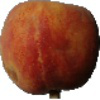

In [25]:
peach_path = "./Test/26_100.jpg"

img = tf.keras.utils.load_img(
    peach_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Identified to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(peach_path))